In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm import tqdm
from sklearn.utils import check_random_state

from dataset import SyntheticSlateBanditDataset
from policy import gen_eps_greedy
from estimator import SlateInversePropensityScore as IPS
from util import SlateOffPolicyEvaluation, aggregate_simulation_results, visualize_mean_squared_error

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
# setting 1

# 変数
val_sizes=[100, 500, 1000, 2000, 3000]

# 定数
behavior_ratio = {"independent": 1.0, "cascade": 0.0, "all": 0.0}
test_size=100000
n_sim=50
dim_context=3
n_actions=3
len_list=3
alpha = np.ones(len_list)
eps=0.5
return_pscore={"all": True, "independent": True, "cascade": False, "adaptive": False}
estimator_to_pscore_dict={"SIPS": "all", "IIPS": "independent"}
random_state=12345

In [15]:
# experiment-1 varying data size under independent user behavior

dataset = SyntheticSlateBanditDataset(
    n_unique_action=n_actions,
    len_list=len_list,
    dim_context=dim_context,
    behavior_ratio=behavior_ratio,
    random_state=12345
)
# calculate ground truth policy value
test_return_pscore={"all": False, "independent": False, "cascade": False, "adaptive": False}
test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, return_pscore=test_return_pscore)

expected_reward_factual = test_data["expected_reward"][np.arange(test_size),test_data["user_behavior_id"]]
policy_value = dataset.calc_ground_truth_policy_value(
    user_behavior_prob=np.array(list(behavior_ratio.values())),
    expected_reward=test_data['expected_reward'],
    evaluation_policy=gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps),
    alpha=alpha
)

result_df_list = []
for val_size in val_sizes:
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"val_size={val_size}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size, return_pscore=return_pscore)
        expected_reward_factual = val_data["expected_reward"][np.arange(val_size), val_data["user_behavior_id"]]
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps)
        _, evaluation_policy_pscore = dataset.aggregate_propensity_score(
            ranking_pi=evaluation_policy, 
            slate_id=val_data["slate_id"],
            user_behavior=val_data["user_behavior"],
            return_pscore=return_pscore
        )
        
        # off policy evaluation
        ope_estimators = [IPS(estimator_name=estimator_name) for estimator_name, _ in estimator_to_pscore_dict.items()]
        ope = SlateOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            estimator_to_pscore_dict=estimator_to_pscore_dict
        )
        estimated_policy_values = ope.estimate_policy_values(
            alpha=alpha, 
            evaluation_policy_pscore=evaluation_policy_pscore
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=val_size
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

val_size=100...: 100% 50/50 [00:13<00:00,  3.60it/s]
val_size=500...: 100% 50/50 [00:32<00:00,  1.52it/s]
val_size=1000...: 100% 50/50 [00:57<00:00,  1.14s/it]
val_size=2000...: 100% 50/50 [01:53<00:00,  2.27s/it]
val_size=3000...: 100% 50/50 [02:37<00:00,  3.14s/it]


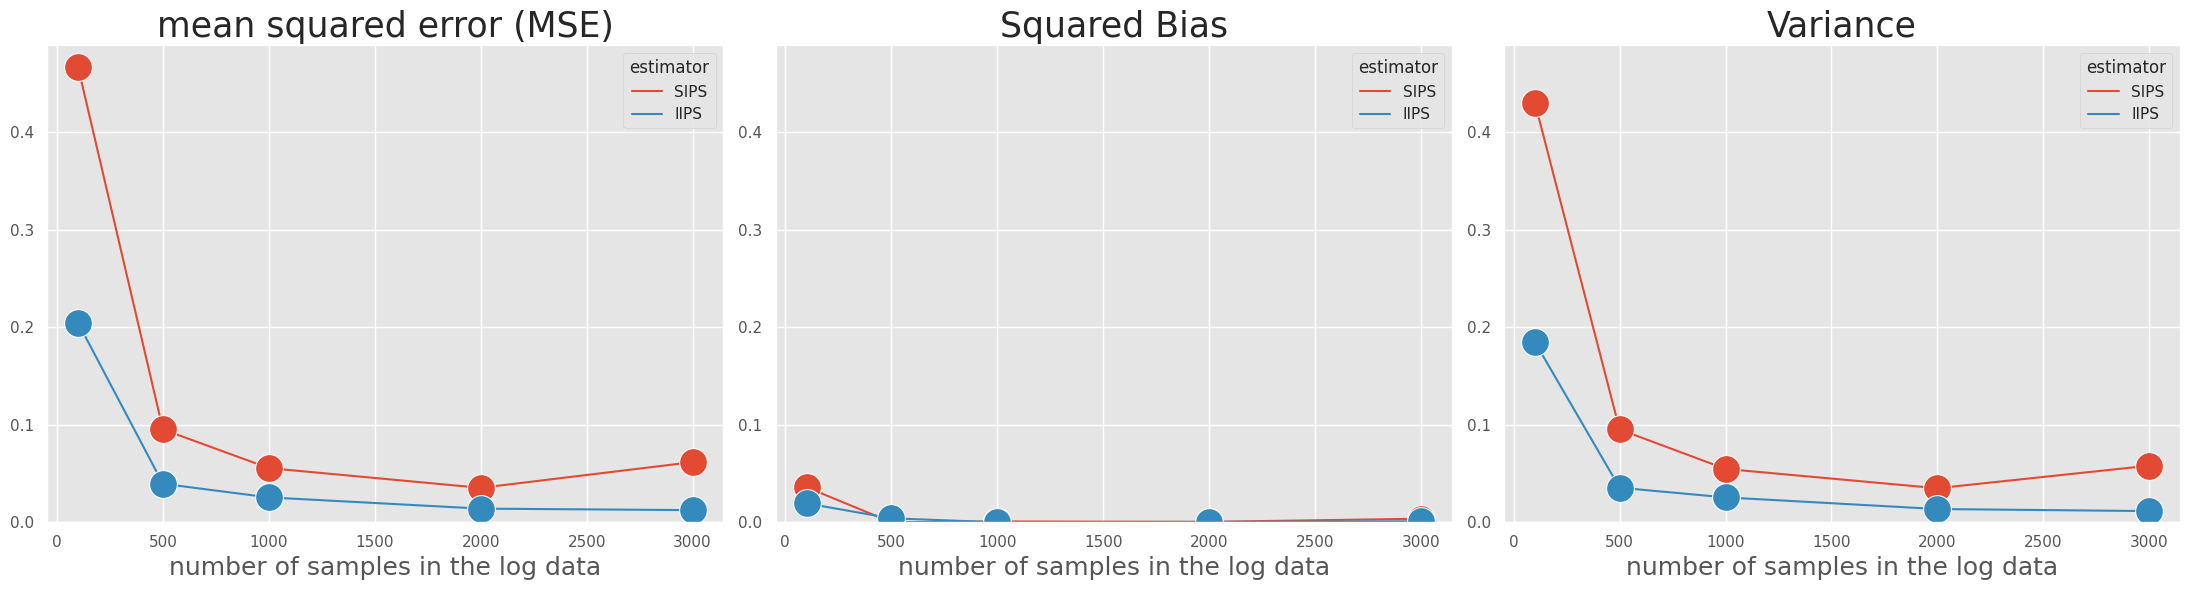

In [17]:
visualize_mean_squared_error(result_df=result_df, xlabel="number of samples in the log data")

In [24]:
# setting 2

# 変数
len_list_list=[1,2,3]

# 定数
behavior_ratio = {"independent": 1.0, "cascade": 0.0, "all": 0.0}
test_size=100000
val_size=1000
n_sim=50
dim_context=3
n_actions=3
eps=0.5
return_pscore={"all": True, "independent": True, "cascade": False, "adaptive": False}
estimator_to_pscore_dict={"SIPS": "all", "IIPS": "independent"}
random_state=12345

In [25]:
# experiment-2 varying len_list under independent user behavior

result_df_list = []
for len_list in len_list_list:
    
    dataset = SyntheticSlateBanditDataset(
        n_unique_action=n_actions,
        len_list=len_list,
        dim_context=dim_context,
        behavior_ratio=behavior_ratio,
        random_state=random_state
    )
    # calculate ground truth policy value
    test_return_pscore={"all": False, "independent": False, "cascade": False, "adaptive": False}
    test_data = dataset.obtain_batch_bandit_feedback(n_rounds=test_size, return_pscore=test_return_pscore)

    expected_reward_factual = test_data["expected_reward"][np.arange(test_size),test_data["user_behavior_id"]]
    alpha = np.ones(len_list)
    policy_value = dataset.calc_ground_truth_policy_value(
        user_behavior_prob=np.array(list(behavior_ratio.values())),
        expected_reward=test_data['expected_reward'],
        evaluation_policy=gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps),
        alpha=alpha
    )
    
    result_list = []
    for _ in tqdm(range(n_sim), desc=f"len_list={len_list}..."):
        
        # generate synthetic data
        val_data = dataset.obtain_batch_bandit_feedback(n_rounds=val_size, return_pscore=return_pscore)
        expected_reward_factual = val_data["expected_reward"][np.arange(val_size), val_data["user_behavior_id"]]
        
        # evaluation policy
        evaluation_policy = gen_eps_greedy(expected_reward=expected_reward_factual, eps=eps)
        _, evaluation_policy_pscore = dataset.aggregate_propensity_score(
            ranking_pi=evaluation_policy, 
            slate_id=val_data["slate_id"],
            user_behavior=val_data["user_behavior"],
            return_pscore=return_pscore
        )
        
        # off policy evaluation
        ope_estimators = [IPS(estimator_name=estimator_name) for estimator_name, _ in estimator_to_pscore_dict.items()]
        ope = SlateOffPolicyEvaluation(
            bandit_feedback=val_data,
            ope_estimators=ope_estimators,
            estimator_to_pscore_dict=estimator_to_pscore_dict
        )
        estimated_policy_values = ope.estimate_policy_values(
            alpha=alpha, 
            evaluation_policy_pscore=evaluation_policy_pscore
        )
        
        result_list.append(estimated_policy_values)
    
    # calculate MSE
    result_df = aggregate_simulation_results(
        simulation_result_list=result_list,
        policy_value=policy_value,
        x_value=len_list
    )
    result_df_list.append(result_df)
        
result_df = pd.concat(result_df_list).reset_index(level=0)

len_list=1...: 100% 50/50 [00:57<00:00,  1.15s/it]
len_list=2...: 100% 50/50 [00:59<00:00,  1.18s/it]
len_list=3...: 100% 50/50 [00:57<00:00,  1.16s/it]


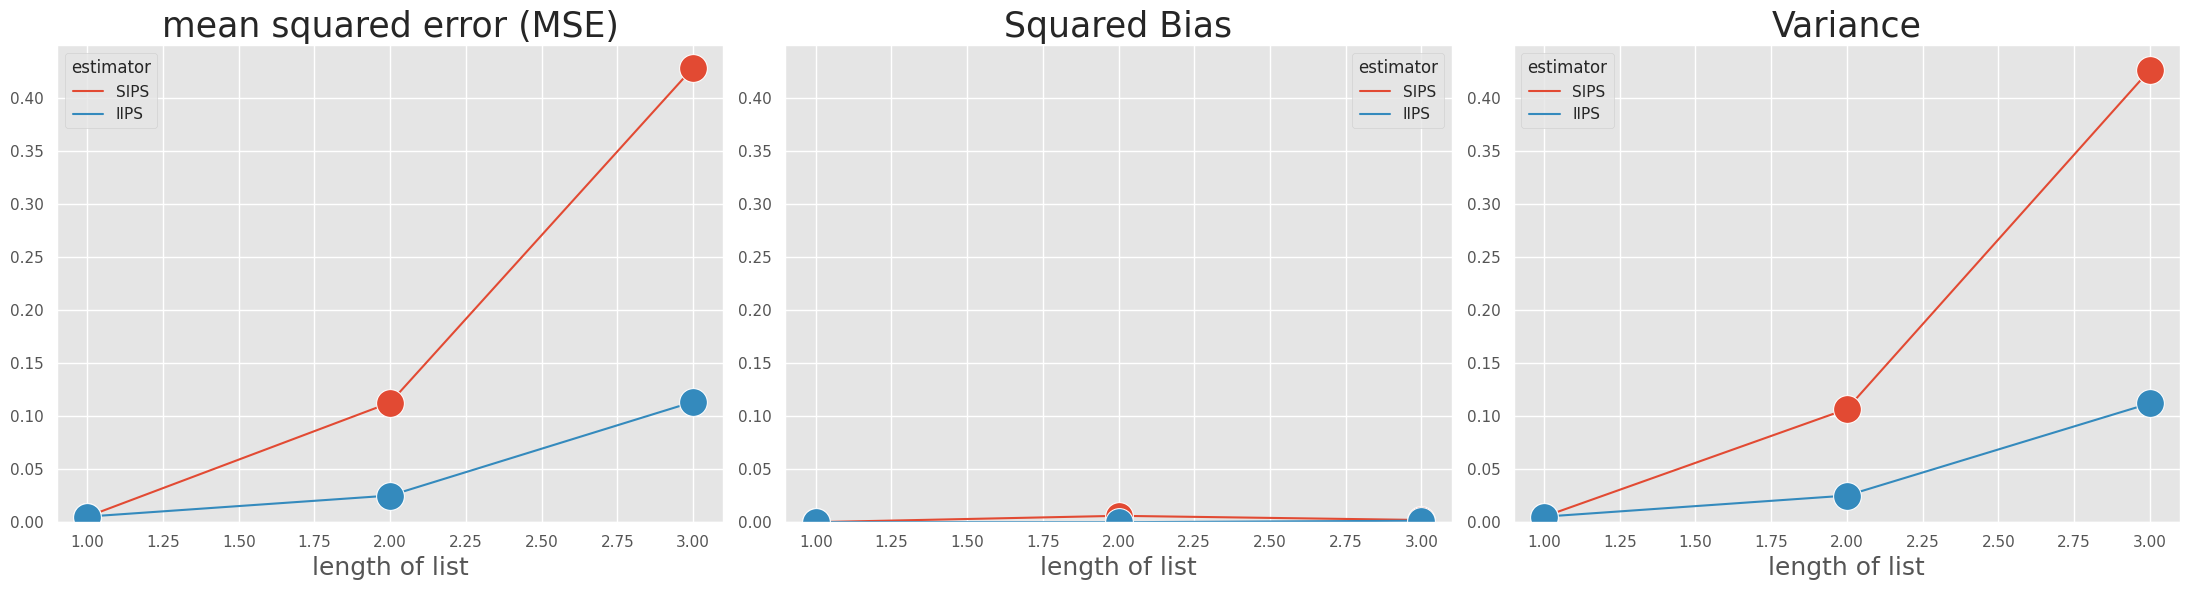

In [26]:
visualize_mean_squared_error(result_df=result_df, xlabel="length of list")